### Big Data Cup - Pass Similarity Project

This notebook explores the analysis found in our project, which won the student section of the 2021 Big Data Cup. Our project uses a k-neighbors approach to find the most similar passes, and uses their probability of success and value added to find how efficient any particular pass is. You can take a look at our presentation [here](https://www.youtube.com/watch?v=W2hFMCsUe0E)!

In [46]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
import math

In [63]:
from ipynb.fs.full.bdc_functions import shot_feature_adder, clocktime, dist
from PIL import Image

rink = Image.open("oz rink.png")
rink = rink.reduce(2)
rink.putalpha(100)

In [48]:
df_scouting = pd.read_csv('hackathon_scouting.csv')

In [49]:
len(df_scouting)

75888

### Data Cleaning, Incorporating xG

This section of the code imports the functions from the other notebook required to train and add an expected goals model to the existing Otters scouting data. Additionally, this xG data is used to find the value generated by each pass in the next 45 seconds (as in the original project) or the next 25 seconds (updated).

In [50]:
#Adding features to the default dataframe to train the expected goals model
#The relative importance of these features is printed below
scouting = shot_feature_adder(df_scouting)

ipynb.fs.full.bdc_functions:55: RuntimeWarning: divide by zero encountered in double_scalars
ipynb.fs.full.bdc_functions:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipynb.fs.full.bdc_functions:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


                  Variable                     Coef
6         Opp Team Skaters     [0.9114534998575123]
11     Last Was Zone Entry     [0.3478350949976765]
15                Snapshot     [0.1835182448216048]
16             Wrap Around    [0.08146291157856334]
7             Is Powerplay    [0.02936772210977209]
5       Lateral Since Last    [0.01144146397533829]
1             Y Coordinate   [0.005495317285350662]
2               Shot Angle  [-0.005922676896347832]
0             X Coordinate  [-0.029896530207717858]
3            Shot Distance   [-0.08401246101100945]
14                Slapshot   [-0.22958214485499442]
10       Last Was Takeaway   [-0.23131747516398457]
9            Last Was Shot   [-0.33861014158795977]
4          Time Since Last   [-0.40017606572186337]
8   Last Was Puck Recovery    [-0.5378708291447075]
12              Deflection    [-0.9754348794554273]
13                     Fan    [-1.1815410112902587]


In [51]:
#This function calculates the xG and Corsi +/- in the following 25 and 45s respectively
#These numbers account for the basis of the value calculation to be used later

#Creating empty columns
scouting['xg_pm_45'] = [np.nan for i in range(len(scouting))]
scouting['xg_pm_25'] = [np.nan for i in range(len(scouting))]
scouting['c_pm_45'] = [np.nan for i in range(len(scouting))]
scouting['c_pm_25'] = [np.nan for i in range(len(scouting))]

#Iterating over dataframe to populate above columns
for i in range(len(scouting)):
    if scouting.loc[i,'Event'] in ['Play', 'Incomplete Play']:
        xg_pm = 0
        xg_pm_short = 0
        c_pm = 0
        c_pm_short = 0
        start_time = clocktime(scouting.loc[i,'Clock'])
        start_team = scouting.loc[i,'Team']
        short_flag = False
        for j in range(i,len(scouting)):
            curr_time = clocktime(scouting.loc[j,'Clock'])
            if curr_time < start_time - 45 or curr_time > start_time:
                break
            if curr_time < start_time - 25 or curr_time > start_time:
                short_flag = True
            if scouting.loc[j,'Event'] in ['Shot', 'Goal']:
                if scouting.loc[j,'Team'] == start_team:
                    xg_pm += scouting.loc[j,'xG']
                    c_pm += 1
                    if short_flag == False:
                        xg_pm_short += scouting.loc[j,'xG']
                        c_pm_short += 1
                else:
                    xg_pm += scouting.loc[j,'xG'] * -1
                    c_pm += -1
                    if short_flag == False:
                        xg_pm_short += scouting.loc[j,'xG'] * -1
                        c_pm_short += -1
            if scouting.loc[j,'Event'] == 'Goal':
                break
        scouting.loc[i,'xg_pm_45'] = xg_pm
        scouting.loc[i,'c_pm_45'] = c_pm
        scouting.loc[i,'c_pm_25'] = c_pm_short
        scouting.loc[i,'xg_pm_25'] = xg_pm_short
    else:
        pass

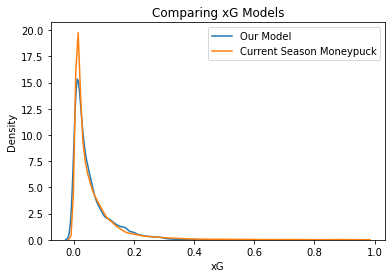

Our AUC Score: 0.8008598419851791 | Moneypuck AUC Score: 0.8156274721734645


In [52]:
#This block of code compares our xG model to the current Moneypuck model as of 3-25-21
mp_shots = pd.read_csv('shots_2020.csv')
sns.distplot(scouting['xG'].dropna(), hist = False, label = 'Our Model')
sns.distplot(mp_shots.xGoal.dropna(), hist = False, label = 'Current Season Moneypuck')
plt.title('Comparing xG Models')
plt.xlabel('xG')
plt.ylabel('Density')
plt.savefig('xg_comp.png', dpi = 200)
#Comparing area under curve scores between ourselves and Moneypuck
mp_auc = roc_auc_score(mp_shots.goal,mp_shots.xGoal)
xgdf = scouting[['Is Goal', 'xG']].dropna()
our_auc = roc_auc_score(xgdf['Is Goal'], xgdf.xG)
plt.show()
print('Our AUC Score: ' + str(our_auc) + " | Moneypuck AUC Score: " + str(mp_auc))

#### Training models to validate KNN usage

Here we train a simple GBC to predict pass completion and a GBR to predict the value of a particular pass using the coordinate data as well as additional features from the xG model. This is meant to roughly approximate which features of a pass are most crucial in determining it's value - confirming the assumption that the X, Y coordinates are most important.

In [53]:
#Paring down dataframe and adding additional features to passes
pass_features = scouting.loc[scouting.Event.isin(['Play', 'Incomplete Play'])]
pass_features = pass_features.loc[pass_features['X Coordinate'] > 125]
pass_features['successful'] = [1 if x == 'Play' else 0 for x in pass_features['Event'].tolist()]
pass_features = pass_features.loc[pass_features['Is Powerplay'] != 1]
pass_features['origin'] = pass_features[['X Coordinate', 'Y Coordinate']].values.tolist()
pass_features['destination'] = pass_features[['X Coordinate 2', 'Y Coordinate 2']].values.tolist()
pass_features.columns
pass_features['Direct'] = [1 if x == 'Direct' else 0 for x in pass_features['Detail 1'].tolist()]

In [54]:
#Selecting features for simple GBC/GBR to determine predictiveness
passX = pass_features[['X Coordinate', 'Y Coordinate', 'Direct', 'X Coordinate 2', 'Y Coordinate 2', 'Time Since Last', 'Lateral Since Last']]
passV = pass_features['xg_pm_45']
passS = pass_features['successful']

In [55]:
#Training a simple GBC to predict successfulness of passes and evaluating most important features
gbc = GradientBoostingClassifier()
X_train, X_test, y_train, y_test = train_test_split(passX, passS, test_size=0.3, random_state=420)
gbc.fit(X_train,y_train)
y_pred = gbc.predict_proba(X_test)
print("Pass Success Predictor Score: " + str(gbc.score(X_test,y_test)))
pd.DataFrame(gbc.feature_importances_, index = passX.columns).sort_values(by=0, ascending = False)

Pass Success Predictor Score: 0.7226861517049409


,0
X Coordinate 2,0.443382
Y Coordinate 2,0.302910
Y Coordinate,0.107392
X Coordinate,0.066920
Time Since Last,0.034803
Lateral Since Last,0.034784
Direct,0.009809


In [56]:
success_odds = [y[1] for y in y_pred]
test_passes = pass_features.loc[y_test.index.tolist()].copy()
test_passes['predicted'] = success_odds

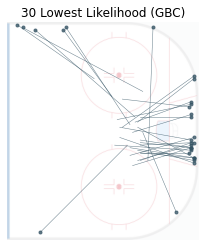

In [57]:
#Plotting the 30 Lowest Likelihood Passes
gbc_pass = test_passes.sort_values('predicted', ascending=True)
fig, ax = plt.subplots()
plt.xlim(125,200)
plt.xticks([], [])
plt.yticks([], [])
plt.ylim(0,85)
plt.imshow(rink, extent=(125,200,0,85))
plt.title('30 Lowest Likelihood (GBC)')
for i in gbc_pass.index.tolist()[:30]:
    x1 = gbc_pass.loc[i,'X Coordinate']
    x2 = gbc_pass.loc[i,'X Coordinate 2']
    y1 = gbc_pass.loc[i,'Y Coordinate']
    y2 = gbc_pass.loc[i,'Y Coordinate 2']
    col = 'k'
#     if effp.loc[i,'similarPassAvgXG'] > .015:
#         col = '#42f587'
#     if pointPasses.loc[i,'similarPassAvgXG'] > .03:
#         col = '#f5ce42'
#     if pointPasses.loc[i,'similarPassAvgXG'] > .045:
#         col = 'r'
    plt.plot([x1,x2],[y1,y2], color = "#355464", markevery=2,lw=.5,marker=".", alpha = .75)
plt.box(False)
#plt.savefig('gbcsafest.png', dpi=200)

In [58]:
#Subsetting successful, direct passes to train the GBR
passX_s = pass_features.loc[(pass_features.successful == 1) & (pass_features.Direct == 1)][['X Coordinate', 'Y Coordinate', 'X Coordinate 2', 'Y Coordinate 2', 'Time Since Last', 'Lateral Since Last']]
passVs= pass_features.loc[(pass_features.successful == 1) & (pass_features.Direct == 1)]['xg_pm_45']

In [59]:
#Training GBR Score - not nearly as significant, XY Coordinates still most predictive features

gbr = GradientBoostingRegressor()
X_train, X_test, y_train, y_test = train_test_split(passX_s, passVs, test_size=0.3, random_state=42)
gbr.fit(X_train,y_train)
y_pred2 = gbr.predict(X_test)
print("GBR Score: " + str(gbr.score(X_test,y_test)))
pd.DataFrame(gbr.feature_importances_, index = passX_s.columns).sort_values(by=0)

GBR Score: 0.031152047419714335


,0
Time Since Last,0.038568
Lateral Since Last,0.074423
X Coordinate,0.099362
Y Coordinate,0.101945
X Coordinate 2,0.266834
Y Coordinate 2,0.418868


In [60]:
exp_val = [y for y in y_pred2]
test_passes = pass_features.loc[y_test.index.tolist()].copy()
test_passes['predicted_val'] = exp_val

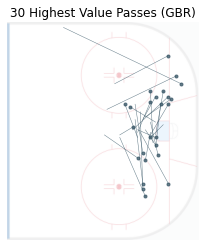

In [61]:
#Plotting the highest GBR Value Passes
gbc_pass = test_passes.sort_values('predicted_val', ascending=False)
fig, ax = plt.subplots()
plt.xlim(125,200)
plt.xticks([], [])
plt.yticks([], [])
plt.ylim(0,85)
plt.imshow(rink, extent=(125,200,0,85))
plt.title('30 Highest Value Passes (GBR)')
for i in gbc_pass.index.tolist()[:25]:
    x1 = gbc_pass.loc[i,'X Coordinate']
    x2 = gbc_pass.loc[i,'X Coordinate 2']
    y1 = gbc_pass.loc[i,'Y Coordinate']
    y2 = gbc_pass.loc[i,'Y Coordinate 2']
    col = 'k'
#     if effp.loc[i,'similarPassAvgXG'] > .015:
#         col = '#42f587'
#     if pointPasses.loc[i,'similarPassAvgXG'] > .03:
#         col = '#f5ce42'
#     if pointPasses.loc[i,'similarPassAvgXG'] > .045:
#         col = 'r'
    plt.plot([x1,x2],[y1,y2], color = "#355464", markevery=2,lw=.5,marker=".", alpha = .75)
plt.box(False)
#plt.savefig('gbrdanger.png', dpi=200)

#### Training KNN Model

This portion of the code uses the X, Y Coordinate data to locate the nearest matches to each individual pass by finding the smallest euclidean distance between two passes' start and endpoints. This makes up the basis of our code's runtime, and is only applied to passes in the offensive zone as a result. Summarizing the KNN model allows us to predict a pass' expected completion rate and it's value to the team within a short time period.

In [64]:
passes = pass_features.loc[pass_features['X Coordinate'] > 125].reset_index(drop = False)

nearest = []
nearest_d = []

for i in range(len(passes)):
    dists = []
    ix = passes.loc[i,'X Coordinate']
    for j in range(len(passes)):
        o_dist = dist(passes.loc[i,'origin'], passes.loc[j,'origin'])
        d_dist = dist(passes.loc[i,'destination'], passes.loc[j,'destination'])
        comb_dist = o_dist + d_dist
        dists.append(comb_dist)
    nearest_d.append(sorted(dists)[:100])
    nearest.append(sorted(range(len(dists)), key=lambda k: dists[k])[:100])
    if i % 100 == 0:
        print(str(i) + " out of " + str(len(passes)))
    
passes['nearest'] = nearest
passes['nearest_d'] = nearest_d
#passes.to_csv('test.csv')

0 out of 9580
100 out of 9580
200 out of 9580
300 out of 9580
400 out of 9580
500 out of 9580
600 out of 9580
700 out of 9580
800 out of 9580
900 out of 9580
1000 out of 9580
1100 out of 9580
1200 out of 9580
1300 out of 9580
1400 out of 9580
1500 out of 9580
1600 out of 9580
1700 out of 9580
1800 out of 9580
1900 out of 9580
2000 out of 9580
2100 out of 9580
2200 out of 9580
2300 out of 9580
2400 out of 9580
2500 out of 9580
2600 out of 9580
2700 out of 9580
2800 out of 9580
2900 out of 9580
3000 out of 9580
3100 out of 9580
3200 out of 9580
3300 out of 9580
3400 out of 9580
3500 out of 9580
3600 out of 9580
3700 out of 9580
3800 out of 9580
3900 out of 9580
4000 out of 9580
4100 out of 9580
4200 out of 9580
4300 out of 9580
4400 out of 9580
4500 out of 9580
4600 out of 9580
4700 out of 9580
4800 out of 9580
4900 out of 9580
5000 out of 9580
5100 out of 9580
5200 out of 9580
5300 out of 9580
5400 out of 9580
5500 out of 9580
5600 out of 9580
5700 out of 9580
5800 out of 9580
5900 out 

In [65]:
#compute expected completion percentage/ avg xG
passes = pd.read_csv('test.csv', index_col = 0)
passes['nearest'] = passes.nearest.str.strip('[').str.strip(']').str.split(',')
passes['nearest_d'] = passes.nearest_d.str.strip('[').str.strip(']').str.split(',')
xG_comp = []
xG_fail = []
completion_rate = []
for index_to_test in range(len(passes)):
    temp_completion_rate = []
    tempXG_comp = []
    tempXG_fail = []
    j = 0
    while j < 50:
        i = int(passes.loc[index_to_test,'nearest'][j].strip(' '))
        if i == index_to_test:
            pass
        elif passes.loc[i,'Event'] == 'Play':
            tempXG_comp.append(passes.loc[i, 'xg_pm_45'])
            temp_completion_rate.append(1)
        else:
            tempXG_fail.append(passes.loc[i, 'xg_pm_45'])
            temp_completion_rate.append(0)
        j += 1
    xG_comp.append(sum(tempXG_comp)/len(tempXG_comp))
    xG_fail.append(sum(tempXG_fail)/len(tempXG_fail))
    completion_rate.append(sum(temp_completion_rate)/len(temp_completion_rate))

    
passes['similarCompXG'] = xG_comp
passes['similarFailXG'] = xG_fail
passes['expectedCompletionRate'] = completion_rate
#float(passes.loc[1,'nearest_d'][j].strip(' '))

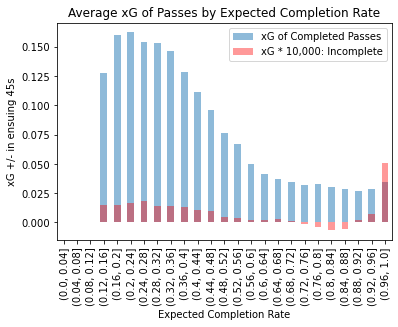

In [66]:
from pandasql import sqldf
bins = [x/25 for x in range(26)]
p_mean = passes.groupby(pd.cut(passes.expectedCompletionRate, bins)).mean().iloc[:,:-1]
p_count = passes.groupby(pd.cut(passes.expectedCompletionRate, bins)).count().iloc[:,:-1]
p_mean['count'] = p_count['index']
pass_summary = p_mean[['similarCompXG', 'similarFailXG', 'count']].reset_index(drop=False)
pass_summary

fig, ax = plt.subplots()
pass_summary.plot.bar('expectedCompletionRate','similarCompXG', alpha=.5, ax=ax, label = 'xG of Completed Passes')
pass_summary.plot.bar('expectedCompletionRate','similarFailXG', alpha=.4, ax=ax, label = 'xG * 10,000: Incomplete', color = 'r')
#pass_summary.plot.bar('expectedCompletionRate','count', alpha=.4, ax=ax, color='r')
ax.set_title("Average xG of Passes by Expected Completion Rate")
ax.set_ylabel('xG +/- in ensuing 45s')
ax.set_xlabel('Expected Completion Rate')
plt.show()
#pass_summary

#### EDA & Analysis

This section of the code is dedicated to analyzing the data and determining its results. This is discussed more in-depth within the powerpoint presentation as well.

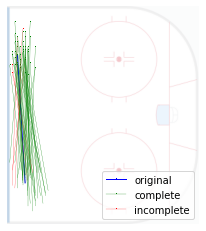

In [67]:
#Plotting a single pass' nearest neighbors
index_to_test = 33
plt.xticks([], [])
plt.yticks([], [])

plt.imshow(rink, extent=(125,200,0,85))

plt.ylim(0,85)
plt.xlim(125,200)
pc = 0
ic = 0
for i in passes.loc[index_to_test,'nearest'][:50]:
    i = int(i.strip(' '))
    x1 = passes.loc[i,'X Coordinate']
    x2 = passes.loc[i,'X Coordinate 2']
    y1 = passes.loc[i,'Y Coordinate']
    y2 = passes.loc[i,'Y Coordinate 2']
    if i == index_to_test:
        plt.plot([x1,x2],[y1,y2],'b,-', markevery=2,lw=1, label = 'original')
    elif passes.loc[i,'Event'] == 'Play':
        if pc == 0:
            plt.plot([x1,x2],[y1,y2],'g,-', markevery=2,lw=0.25, label = 'complete')
            pc += 1
        else:
            plt.plot([x1,x2],[y1,y2],'g,-', markevery=2,lw=0.25)
    else:
        if ic == 0:
            plt.plot([x1,x2],[y1,y2],'r,-', markevery=2,lw=0.2, label = 'incomplete')
            ic += 1
        else:
            plt.plot([x1,x2],[y1,y2],'r,-', markevery=2,lw=0.2)
plt.legend(loc='lower right')
plt.box(False)
#plt.savefig('nearest.png', dpi = 200)

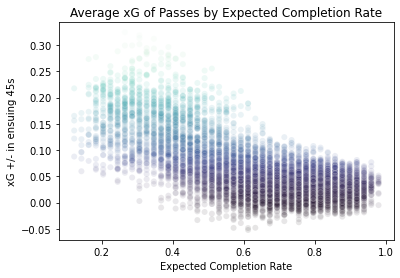

In [68]:
#Plotting the negative relationship between completion rate and value
fig, ax = plt.subplots()
sns.scatterplot(x='expectedCompletionRate', y = 'similarCompXG', data = passes, alpha = .1, ax=ax, hue = 'similarCompXG', palette = 'mako')
ax.set_title("Average xG of Passes by Expected Completion Rate")
ax.set_ylabel('xG +/- in ensuing 45s')
ax.set_xlabel('Expected Completion Rate')
ax.get_legend().remove()
plt.savefig('xg_vs_comp.png', dpi = 200)

In [69]:
avg_incomplete_xg = passes.loc[passes.Event == 'Incomplete Play']['xg_pm_45'].mean()
passes['efficiency'] = passes['expectedCompletionRate'] * passes['similarCompXG']

In [70]:
effp = passes.sort_values('similarCompXG', ascending = False)

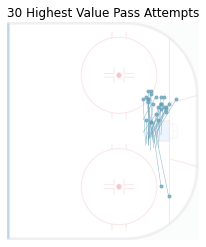

In [71]:
#Plotting the highest value pass attempts
fig, ax = plt.subplots()
plt.xlim(125,200)
plt.xticks([], [])
plt.yticks([], [])
plt.ylim(0,85)
plt.imshow(rink, extent=(125,200,0,85))
plt.title('30 Highest Value Pass Attempts')
for i in effp.index.tolist()[:30]:
    x1 = effp.loc[i,'X Coordinate']
    x2 = effp.loc[i,'X Coordinate 2']
    y1 = effp.loc[i,'Y Coordinate']
    y2 = effp.loc[i,'Y Coordinate 2']
    col = 'k'
#     if effp.loc[i,'similarPassAvgXG'] > .015:
#         col = '#42f587'
#     if pointPasses.loc[i,'similarPassAvgXG'] > .03:
#         col = '#f5ce42'
#     if pointPasses.loc[i,'similarPassAvgXG'] > .045:
#         col = 'r'
    plt.plot([x1,x2],[y1,y2], color = "#68a2b9", markevery=2,lw=.5,marker=".", alpha = .75)
plt.box(False)
plt.savefig('dangerousest.png', dpi=200)

In [72]:
#Subsetting data to indirect passes
pointPasses = passes.loc[(passes['X Coordinate'] <1) & (passes['Detail 1'] != 'Indirect')]
pointPassesReg = pointPasses.copy()
pointPassesReg['efficiency'] = pointPassesReg['expectedCompletionRate'] * pointPassesReg['similarCompXG']

In [73]:
passes['value'] = passes['successful'] * passes['xg_pm_45']
passes['eff_delta'] = passes.value - passes.efficiency

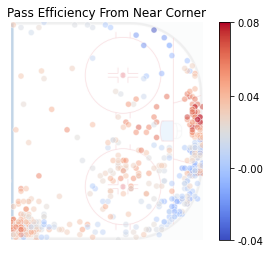

In [77]:
#Plotting the most efficient passes from the near corner
pointPassesReg = passes.loc[(passes['X Coordinate'] < 200) & (passes['X Coordinate'] > 185)].copy()
pointPassesReg = pointPassesReg.loc[(pointPassesReg['Y Coordinate'] < 20) & (pointPassesReg['Y Coordinate'] > 0)]
#pointPassesReg = passes.loc[passes.Player == 'Chad Yetman']
plt.xlim(125,200)
plt.imshow(rink, extent=(125,200,0,85))
plt.ylim(0,85)
plt.title('Pass Efficiency From Near Corner')
pointPassesReg.sort_values('efficiency', ascending = False)
ax = sns.scatterplot(x='X Coordinate 2', y='Y Coordinate 2', data = pointPassesReg, hue = 'efficiency', \
                alpha = .5, palette = 'coolwarm')
sm = plt.cm.ScalarMappable(cmap="coolwarm")
plt.xticks([], [])
plt.yticks([], [])
plt.ylabel('')
plt.xlabel('')
plt.box(False)
cbar = ax.figure.colorbar(sm)
cbar.set_ticks([0, .33,0.66, 1])
cbar.set_ticklabels(['-0.04', '-0.00', '0.04', '0.08'])
#plt.colorbar(ax)
ax.get_legend().remove()
plt.savefig('yetmaneff.png', dpi=200)

In [80]:
#Summarizing Pass Stats by player
player_df = passes.loc[passes.Team == 'Erie Otters'].groupby('Player').mean()
player_df['delta'] = player_df['value'] - player_df['efficiency']
#Adding positions manually
pos = []
for i in player_df.index.tolist():
    if i in ["Jamie Drysdale",
"Jacob Golden",
"Drew Hunter",
"Kurtis Henry",
"Jack Duff",
"Cameron Morton",
"Brendan Kischnick",
"Luke Beamish",
"Christian Kyrou"]:
        pos.append('D')
    else:
        pos.append('F')
player_df['Position'] = pos

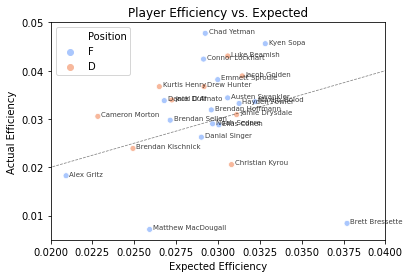

In [89]:
#Plotting Player Efficiency vs. Expected - an application of individual pass data to player evaluation
fig, ax = plt.subplots()

ax.plot([0,1],[0,1], color = 'k', alpha = 0.5, linestyle = 'dashed', lw = .75)
ax.set_xlim(.02,.04)
ax.set_ylim(.005,.05)
sns.scatterplot(ax = ax, data = player_df, x = 'efficiency', y = 'value', hue = 'Position', palette = 'coolwarm')
ax.set_xlabel("Expected Efficiency")
ax.set_ylabel("Actual Efficiency")
ax.set_title('Player Efficiency vs. Expected')
for i in player_df.index.tolist():
    ax.text(player_df.loc[i,'efficiency'] + .0002, player_df.loc[i,'value'], i, size = 7, alpha = .75)
plt.savefig('testjpg.png', dpi = 200)

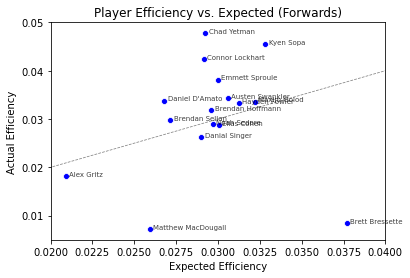

In [90]:
#Same graph as above but isolating forwards
fig, ax = plt.subplots()
ax.plot([0,1],[0,1], color = 'k', alpha = 0.5, linestyle = 'dashed', lw = .75)
ax.set_xlim(.02,.04)
ax.set_ylim(.005,.05)
sns.scatterplot(ax = ax, data = player_df[player_df.Position == 'F'], x = 'efficiency', y = 'value', color = 'b')
ax.set_xlabel("Expected Efficiency")
ax.set_ylabel("Actual Efficiency")
ax.set_title('Player Efficiency vs. Expected (Forwards)')
for i in player_df.index.tolist():
    if player_df.loc[i,'Position'] == "F":
        ax.text(player_df.loc[i,'efficiency'] + .0002, player_df.loc[i,'value'], i, size = 7, alpha = .75)
plt.savefig('f_png.png', dpi = 200)